This part is the continuation of the R script, the first part of R(bootstraping) is in the Group5_lab5_R file. The work was divided in two parts because there were problems with the code when both parts were put together.

# Causal Tree - Only script in R

1.

In [1]:
## loading the data
data <- as.data.frame(read.table("../data/penn_jae.dat", header=T ))
n <- dim(data)[1]
p_1 <- dim(data)[2]
data<- subset(data, tg== 4| tg==0)
attach(data)
T4<- (tg==4)
T4<-as.numeric(T4)
data=cbind(data,T4)


In [2]:
head(data)

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld,T4
1,10824,0,18,18,0,0,0,0,2,0,...,0,0,0,0,0,0,0,1,0,0
4,10824,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12,10607,4,9,9,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
13,10831,0,27,27,0,0,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0
14,10845,0,27,27,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [3]:
# Treatment: does the the gov't spend too much on "welfare" (1) or "assistance to the poor" (0)
treatment <- "T4"
# Outcome: 1 for 'yes', 0 for 'no'
outcome <- "log(inuidur1)"

# Additional covariates
covariates <- c("female", "black", "othrace", "factor(dep)", "q2", "q3","q4","q5","q6","agelt35","agegt54","durable","lusd","husd")


In [4]:
#install.packages("grf")
library(causalTree)
library(grf)
library(rpart)
library(glmnet)
library(splines)
library(MASS)
library(lmtest)
library(sandwich)
library(ggplot2)

Loading required package: rpart
Loading required package: rpart.plot
Loading required package: data.table
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [5]:
m <- lm(log(inuidur1)~T4*female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd,data=data)
coeftest(m, vcov = vcovHC(m, type="HC2"))


t test of coefficients:

               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)   2.1866134  0.1546279 14.1411 < 2.2e-16 ***
T4           -0.1067286  0.0456101 -2.3400  0.019321 *  
female        0.0965599  0.0431095  2.2399  0.025142 *  
black        -0.2949657  0.0594562 -4.9611 7.240e-07 ***
othrace      -0.4681574  0.2438624 -1.9198  0.054944 .  
factor(dep)1  0.0285410  0.0542094  0.5265  0.598567    
factor(dep)2  0.0955944  0.0463860  2.0608  0.039369 *  
q2            0.0792115  0.1518598  0.5216  0.601965    
q3           -0.0333002  0.1516822 -0.2195  0.826239    
q4           -0.0495716  0.1520543 -0.3260  0.744428    
q5           -0.1380873  0.1518515 -0.9094  0.363204    
q6            0.0059989  0.1633621  0.0367  0.970708    
agelt35      -0.1645460  0.0370277 -4.4439 9.024e-06 ***
agegt54       0.2285792  0.0578868  3.9487 7.963e-05 ***
durable       0.1265560  0.0481703  2.6273  0.008633 ** 
lusd         -0.1753120  0.0404572 -4.3333 1.497e-05 ***
husd 

# 2. Casual trees

In [6]:
indices <- split(seq(nrow(data)), sort(seq(nrow(data)) %% 3))
names(indices) <- c('split', 'est', 'test')

In [7]:
# Fitting the forest
ct.unpruned <- honest.causalTree(
  formula=lm(log(inuidur1)~T4+ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)), # Define the model
  data=data[indices$split,],
  treatment=data[indices$split, treatment],
  est_data=data[indices$est,],
  est_treatment=data[indices$est, treatment],
  minsize=1,                 # Min. number of treatment and control cases in each leaf
  HonestSampleSize=length(indices$est), #  Num obs used in estimation after splitting
  
  # We recommend not changing the parameters below
  split.Rule="CT",            # Define the splitting option
  cv.option="TOT",            # Cross validation options
  cp=0,                       # Complexity parameter
  split.Honest=TRUE,          # Use honesty when splitting
  cv.Honest=TRUE              # Use honesty when performing cross-validation
)

[1] 2
[1] "CT"


In [8]:
# Table of cross-validated values by tuning parameter.
ct.cptable <- as.data.frame(ct.unpruned$cptable)

In [9]:
# Obtain optimal complexity parameter to prune tree.
cp.selected <- which.min(ct.cptable$xerror)

In [10]:
cp.optimal <- ct.cptable[cp.selected, "CP"]

# Prune the tree at optimal complexity parameter.
ct.pruned <- prune(tree=ct.unpruned, cp=cp.optimal)

In [11]:
# Predict point estimates (on estimation sample)
tau.hat.est <- predict(ct.pruned, newdata=data[indices$est,])

# Create a factor column 'leaf' indicating leaf assignment in the estimation set
num.leaves <- length(unique(tau.hat.est))
leaf <- factor(tau.hat.est, levels=sort(unique(tau.hat.est)), labels = seq(num.leaves))

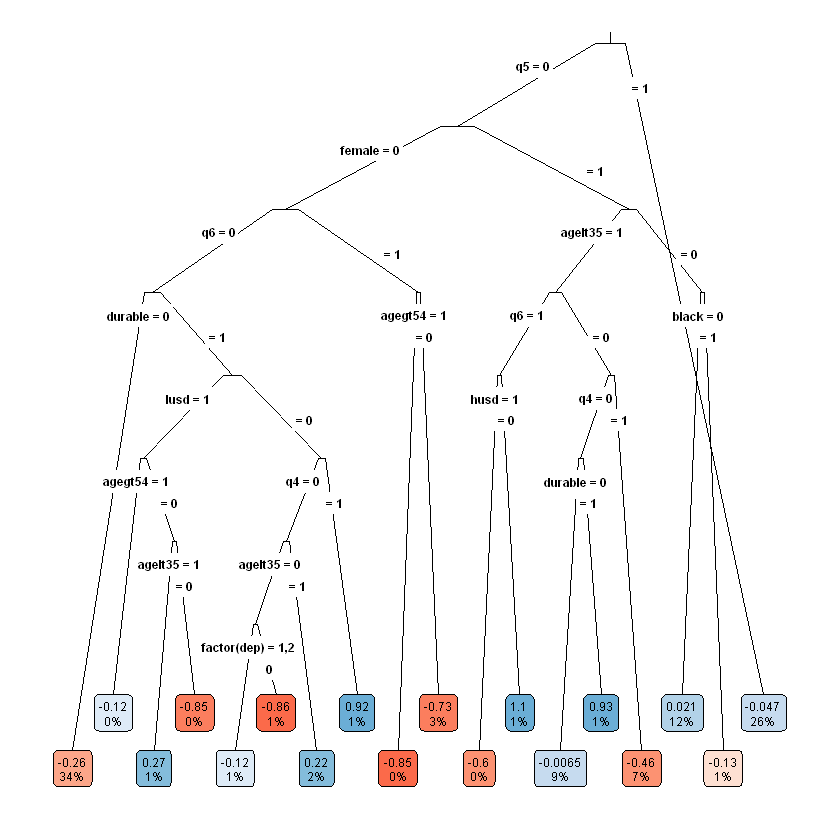

In [12]:
rpart.plot(
  x=ct.pruned,        # Pruned tree
  type=3,             # Draw separate split labels for the left and right directions
  fallen=TRUE,        # Position the leaf nodes at the bottom of the graph
  leaf.round=1,       # Rounding of the corners of the leaf node boxes
  extra=100,          # Display the percentage of observations in the node
  branch=.1,          # Shape of the branch lines
  box.palette="RdBu") # Palette for coloring the node

### Plot the pruned tree and explain the HTE you found.

For the subgroup where q(quarter of the experiment where the participant was enrolled)=5, female=0(male), q6=0, durable=0(occupation not in the manufacturing sector) and agegt54(older than 54 years)=1, the HTE is -0.26. 
Where the most positive HTE was for the subgroup where q5=0, female=1,agelt35=1,q6=1,Husd=0 with a value of 1.1.
On the contrary, the most negative HTE was for the subgroup where q5=0, female=0,q6=0,durable=1,lusd=0,q4=0,agelt35=0,factor(dep)=0 with a value of -0.86.

### Explain why we need to partitionate the data in three sets.

In order to correctly estimate the heterogeneity in the treatment effects it is necessary to subdivide the sample because using the same sample for each step (adaptive method) would create an overfitting problem. 


### Why do we need to use the honest.causalTree function?


The problem with adaptive methods is that they do not perform data partitioning and used the same data for tree creation and for estimating heterogeneous treatment effects. So, this function allows us to estimate causal effects with data different from the data used for tree creation and testing.

### Explain in detail the creation of the tree and how do you choose the optimal pruned tree




First we divide our data into three: split, estimation and test. Where the split data is used to create a tree in which we maximize the heterogeneity in the estimated treatment effect across leaves. The estimation data is used in the tree created in the previous step to estimate the heterogeneous treatment effect on each leaf. Finally the test data is used to check if the estimates are the same as the true values.
For the selection of the optimal pruned tree it is necessary to obtain an optimal complexity parameter. This parameter selects the node where the error is minimized and starts to cut the tree. Different methods can be used to calculate the error. TOT,CT, fit and matching.
